# Milestone 1

## 1-D Burgers Equation
$u_{t} + \lambda uu_{x} = \nu u_{xx}$

In [ ]:
#@uthor : $um@nth Nethi

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, InputLayer, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import glorot_normal
import scipy.io

In [ ]:
pip install livelossplot

In [ ]:
pip install pyDOE

  Created wheel for pyDOE: filename=pyDOE-0.3.8-cp36-none-any.whl size=18178 sha256=98c51cb686846db547ce34e575808fb8ba3f5bcc817173ee595682401508d292
  Stored in directory: /root/.cache/pip/wheels/7c/c8/58/a6493bd415e8ba5735082b5e0c096d7c1f2933077a8ce34544
Successfully built pyDOE


In [ ]:
from pyDOE import lhs
from livelossplot import PlotLossesKerasTF

### Input $\lambda$ and $\nu$ 

In [ ]:
L = float(eval(input('lambda   : ')))
nu = float(eval(input('nu   : ')))

lambda   : 1
nu   : 0.01/np.pi


### Input x & t limits
$x \in [x_1, x_2]$\
$t\ \in [0, t]$

In [ ]:
x1 = float(input('x1   : '))
x2 = float(input('x2   : '))
t = float(input('t    : '))
x = np.linspace(x1, x2, 512)
t = np.linspace(0, t, 256)

x1   : -1
x2   : 1
t    : 1


### Input Boundary and Initial Conditions
$u(x1, t) = u_{0}(t)$  
$u(x2, t) = u_{1}(t)$  
$u(x, 0)\ = g(x)$

In [ ]:
u_x1 = np.array(eval(input('u(x1,t)  : ')))
u_x2 = np.array(eval(input('u(x2,t)  : ')))
u_x =  np.array(eval(input('u(x,0)   : ')))
if u_x1.size==1:
  u_x1 = u_x1*np.ones(256)
if u_x2.size==1:
  u_x2 = u_x2*np.ones(256)
if u_x.size==1:
  u_x = u_x*np.ones(512)

u(x1,t)  : 0
u(x2,t)  : 0
u(x,0)   : -np.sin(np.pi*x)


### Training Data Generation for the Input Conditions

In [ ]:
X, T = np.meshgrid(x,t)
xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T))
xx2 = np.hstack((X[:,0:1], T[:,0:1]))
xx3 = np.hstack((X[:,-1:], T[:,-1:]))
X_train = np.vstack((xx1, xx2, xx3))                                            #Training Data for Boundary Conditions : Contains 2 columns [x, t]
u_x = np.reshape(u_x, (-1,1))
u_x1 = np.reshape(u_x1, (-1,1))
u_x2 = np.reshape(u_x2, (-1,1))
u_train = np.vstack([u_x, u_x2, u_x1])                                          #Corresponding u values of training data
lb = np.array([x1,0])                                                           #Lower bounds of x and t
ub = np.array([x2,max(t)])                                                      #Upper bounds of x and t

X_f_train = lb + (ub-lb)*lhs(2, samples=15000)                                  #Collocation points
X_f_train = np.vstack((X_f_train, X_train))
X_f = tf.convert_to_tensor(X_f_train[:,0:1])         
T_f = tf.convert_to_tensor(X_f_train[:,1:2])

### PINN

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 2)                 0         
_________________________________________________________________
dense (Dense)                (None, 50)                150       
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_4 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_5 (Dense)              (None, 50)                2

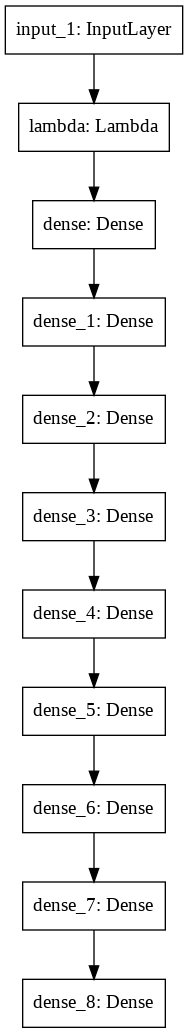

In [ ]:
layers = [2, 50, 50, 50, 50, 50, 50, 50, 50, 1]                                 #Neurons in each layer
def PINN(layers, lb, ub):
  model = Sequential()
  model.add(InputLayer(layers[0],))
  model.add(Lambda(lambda X: 2.0*(X - lb)/(ub - lb) - 1.0))                     #Normalizing all inputs between 0 and 1
  for i in layers[1:-1]:
    model.add(Dense(units=i, activation="tanh", kernel_initializer="glorot_normal"))
  model.add(Dense(units=layers[-1], kernel_initializer="glorot_normal"))
  return model

def custom_loss(model, X_f, T_f, nu, L):
  def loss(u_train, u_pred):
    with tf.GradientTape(persistent=True) as tape:
      tape.watch(X_f)
      tape.watch(T_f)
      xf = tf.stack([X_f[:,0], T_f[:,0]], axis=1) 
      u = tf.cast(model(xf), dtype='float64')
      u_x = tape.gradient(u, X_f)
    u_xx = tape.gradient(u_x, X_f)
    u_t = tape.gradient(u, T_f)
    del tape
    u_train = tf.cast(u_train, dtype='float64')
    u_pred = tf.cast(u_pred, dtype='float64')
    f = u_t + L*u*u_x - nu*u_xx
    loss1 = tf.reduce_mean(tf.square(u_pred - u_train))
    loss2 = tf.reduce_mean(tf.square(f))
    return loss1 + loss2
  return loss

pinn = PINN(layers, lb, ub)
loss_fn = custom_loss(pinn, X_f, T_f, nu, L)
pinn.summary()
keras.utils.plot_model(pinn)

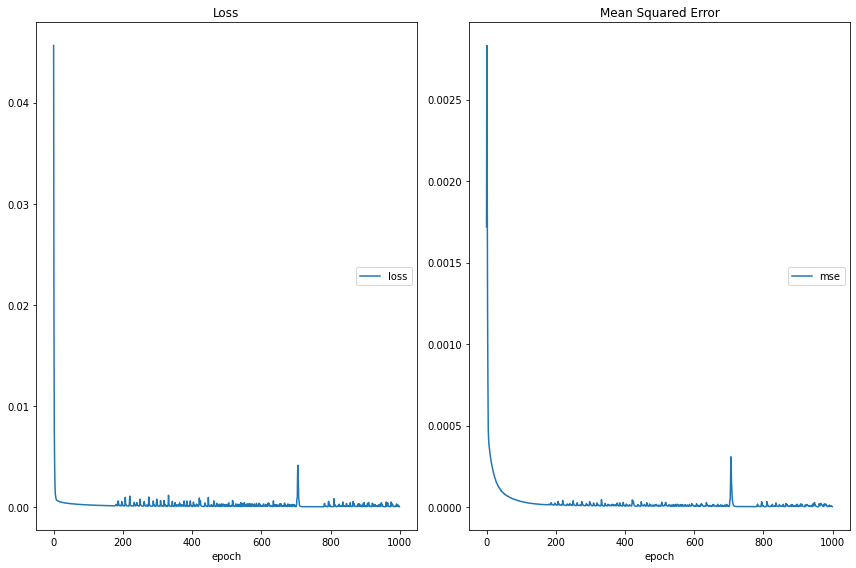

Loss
	loss             	 (min:    0.000, max:    0.046, cur:    0.000)
Mean Squared Error
	mse              	 (min:    0.000, max:    0.003, cur:    0.000)


In [ ]:
plot_loss = PlotLossesKerasTF()
pinn.compile(optimizer=Adam(learning_rate=0.0003, decay= 0.00001), loss=loss_fn, metrics=['mse'])
pinn.fit(X_train, u_train, batch_size=128, epochs=1000, verbose=1, callbacks=[plot_loss])

## Model Testing

In [ ]:
u_test = np.array([[0.6961],[0.6937], [0.6912], [0.6885], [0.6857]])
X_test = np.array([[-0.2314, 0.02],
                   [-0.2235, 0.03],
                   [-0.2157, 0.04],
                   [-0.2078, 0.05],
                   [-0.2000, 0.06]])
u_predicted = pinn.predict(X_test)
table = np.hstack((u_predicted, u_test))
print('Predicted    -    Test')
print(table)

Predicted    -    Test
[[0.69204986 0.6961    ]
 [0.68954998 0.6937    ]
 [0.68715662 0.6912    ]
 [0.68437338 0.6885    ]
 [0.68167895 0.6857    ]]


In [ ]:
l = np.array([[0.69204986 ,0.6961    ],
              [0.68954998 ,0.6937    ],
              [0.68715662 ,0.6912    ],
              [0.68437338 ,0.6885    ],
              [0.68167895 ,0.6857    ]])
error = float(tf.reduce_mean(tf.square(l[:,0:1]-l[:,1:2])))                     #mean square error of predicted data compared to test data
print('Prediction Error :',error)                                               #L2 norm

Prediction Error : 1.6634611514259986e-05


## Save Model
The generated model results are satisfactory

In [ ]:
pinn.save('pinn4.h5')
pinn.save_weights('pinn4_weights.h5')